# 1. Frame the problem and look at the big picture

Oppgave: Vi skal lage en modell som skal klare å forutse hvilke lag som får Man of the Match i fotball. 

Løsning: 
Vi skal bruke et datasett som handler om sommerens fotball-VM i Russland. Ved hjelp av ulike maskinlærings-algoritmer, skal vi lage den beste modellen som er mulig til å forutse framtidige kamper. Modellene våre skal få en input(Ulike data fra kampene), og dermed gi et output som er kalkulert basert på dataen. Vår modell vil være en "supervised learning task" binary classifies, siden vi har fasiten til kampene. 

# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(21)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 2. Get the data

Vi importerer statistikken frå 2018 VM.

In [2]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import seaborn as sns
import csv


In [3]:
data = pd.read_csv("FIFA 2018 Statistics.csv")

# Explore the data to gain insights

For å få et innblikk i hvilken data vi har med å gjøre, så har vi ulike framstillinger av data-settet. 

In [4]:
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 27 columns):
Date                      128 non-null object
Team                      128 non-null object
Opponent                  128 non-null object
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-nul

Her ser vi at noen av attributtene er object, og dette må vi gjøre noe med. Man of the Match-attributten må vi se nærmere på.

In [6]:
data["Man of the Match"].value_counts()

Yes    64
No     64
Name: Man of the Match, dtype: int64

In [7]:
data.describe()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,...,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Goals in PSO,Own goals,Own goal Time
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,94.000000,128.000000,12.0,12.000000
mean,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,1.343750,14.890625,2.726562,...,462.648438,106.664062,13.546875,1.695312,0.015625,0.015625,39.457447,0.203125,1.0,45.833333
std,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,1.193404,4.724262,2.049447,...,151.186311,11.749537,4.619131,1.325454,0.124507,0.124507,24.496506,0.807049,0.0,29.978275
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,12.000000
25%,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,...,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,18.250000,0.000000,1.0,21.750000
50%,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,...,462.000000,104.500000,13.000000,2.000000,0.000000,0.000000,39.000000,0.000000,1.0,35.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,2.000000,18.000000,4.000000,...,555.250000,109.000000,16.000000,2.000000,0.000000,0.000000,54.750000,0.000000,1.0,75.750000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,...,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,90.000000,4.000000,1.0,90.000000


In [8]:
missing_values = data.isnull().sum().sort_values(ascending = False)
percentage_missing_values = (missing_values/len(data))*100
pd.concat([missing_values, percentage_missing_values], axis = 1, keys= ['Missing values', '% Missing'])

,Missing values,% Missing
Own goal Time,116,90.6250
Own goals,116,90.6250
1st Goal,34,26.5625
Free Kicks,0,0.0000
Team,0,0.0000
Opponent,0,0.0000
Goal Scored,0,0.0000
Ball Possession %,0,0.0000
Attempts,0,0.0000
On-Target,0,0.0000


Her ser vi manglende data i data-settet på de ulike attributtene(imputing). Own goal time, Own Goals og 1st goal mangler data. 
Vi bestemmer oss for å fikse disse og lager nye. Man of the Match setter vi til en ny attributt motm. og bruker bolske verdiane 1 og 0. Own goals setter vi all manglende data-rader til 0. Vi lager en bolsk variabel boolFirstGoal som forteller oss hvilket lag som tok ledelsen, visst det er tilfelle. Vi lager winner-attributt, som setter laget som vant til 1, laget som tapte til 0 og visst det endte uavgjort blir den satt til 0.5(gjelder kampene som var i gruppespillet).

In [9]:
def ManOfTheMatchConverter():
    for x in range(0, len(data)):
        if data.loc[x]["Man of the Match"] == 'No':
            data.loc[x, 'motm'] = 0
        else:
            data.loc[x, 'motm'] = 1

In [10]:
import math
def OwnGoalsNanToZero ():
    for x in range(0, len(data)):
        if(math.isnan(data.loc[x]["Own goals"])):
            data.loc[x, 'Own goals'] = math.floor(0)
            



In [11]:
def firstGoal():
    for x in range(0, len(data)):
        if(math.isnan(data.loc[x]["1st Goal"])):
            data.loc[x, 'boolFirstGoal'] = 0
        else:
                data.loc[x, 'boolFirstGoal'] = 1
            

In [12]:
def winnerOfTheMatch():
    for x in range(0, int(len(data)/2)):
        index = x+x;
        lagEnMaal = data.loc[index]["Goal Scored"];
        lagToMaal = data.loc[index+1]["Goal Scored"];
        
        if(data.loc[index, 'Round'] != 'Group Stage' and data.loc[index, 'PSO'] == 'Yes'):
            PSOEnMaal = data.loc[index]["Goals in PSO"];
            PSOToMaal = data.loc[index+1]["Goals in PSO"];
            
            if(PSOEnMaal > PSOToMaal):
                data.loc[index, 'Winner'] = 1;
                data.loc[index+1, 'Winner'] = 0;
            elif(PSOEnMaal < PSOToMaal):
                data.loc[index+1, 'Winner'] = 1;
                data.loc[index, 'Winner'] = 0;
        else:
            if(lagEnMaal > lagToMaal):
                data.loc[index, 'Winner'] = 1;
                data.loc[index+1, 'Winner'] = 0;
            elif(lagEnMaal < lagToMaal):
                data.loc[index+1, 'Winner'] = 1;
                data.loc[index, 'Winner'] = 0;
            else:
                data.loc[index+1, 'Winner'] = 0.5;
                data.loc[index, 'Winner'] = 0.5;


In [13]:
ManOfTheMatchConverter()
OwnGoalsNanToZero()
firstGoal()
winnerOfTheMatch()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 30 columns):
Date                      128 non-null object
Team                      128 non-null object
Opponent                  128 non-null object
Goal Scored               128 non-null int64
Ball Possession %         128 non-null int64
Attempts                  128 non-null int64
On-Target                 128 non-null int64
Off-Target                128 non-null int64
Blocked                   128 non-null int64
Corners                   128 non-null int64
Offsides                  128 non-null int64
Free Kicks                128 non-null int64
Saves                     128 non-null int64
Pass Accuracy %           128 non-null int64
Passes                    128 non-null int64
Distance Covered (Kms)    128 non-null int64
Fouls Committed           128 non-null int64
Yellow Card               128 non-null int64
Yellow & Red              128 non-null int64
Red                       128 non-nul

For å visualisere dataen velger vi ut eit lite utdrag av attributtene. 

In [15]:
data_utdrag = ['Goal Scored', 'On-Target', 'Corners', 'Attempts', 'Free Kicks', 'Yellow Card', 'Fouls Committed']

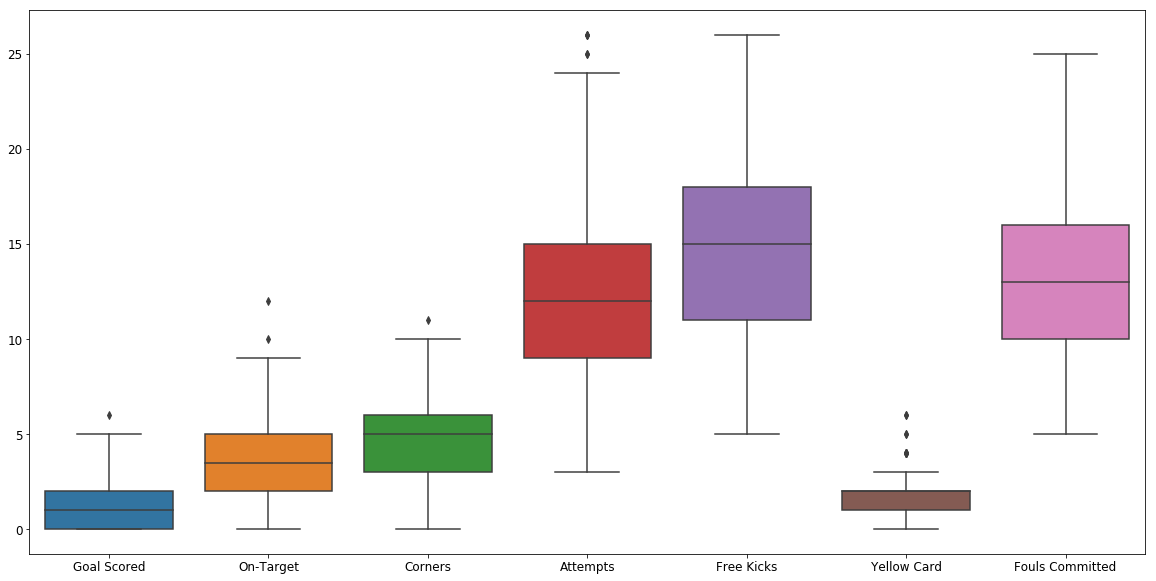

In [16]:
dummy_data = data[data_utdrag]
plt.figure(figsize=(20,10))
sns.boxplot(data = dummy_data)
plt.show()

For hver boxplot er det:

    1 som ligger utenfor normalen i Goal scored
    2 i On-Target
    1 i corners
    2 i Attempts
    3 i Yellow Cards
    i statistikk er en "outlier" et observasjonspunkt som ligger utenfor resten av observasjonene.
    Et punkt utenfor normalen kan være forårsaket av varierte målinger. 
    Mengden "outliers" som er presentert i dette problemet er ikke veldig stort og vil nok ikke ha en stor innvirkning her selv om vi ikke gjør noe med det.
    De er veldig få og innenfor rammen.

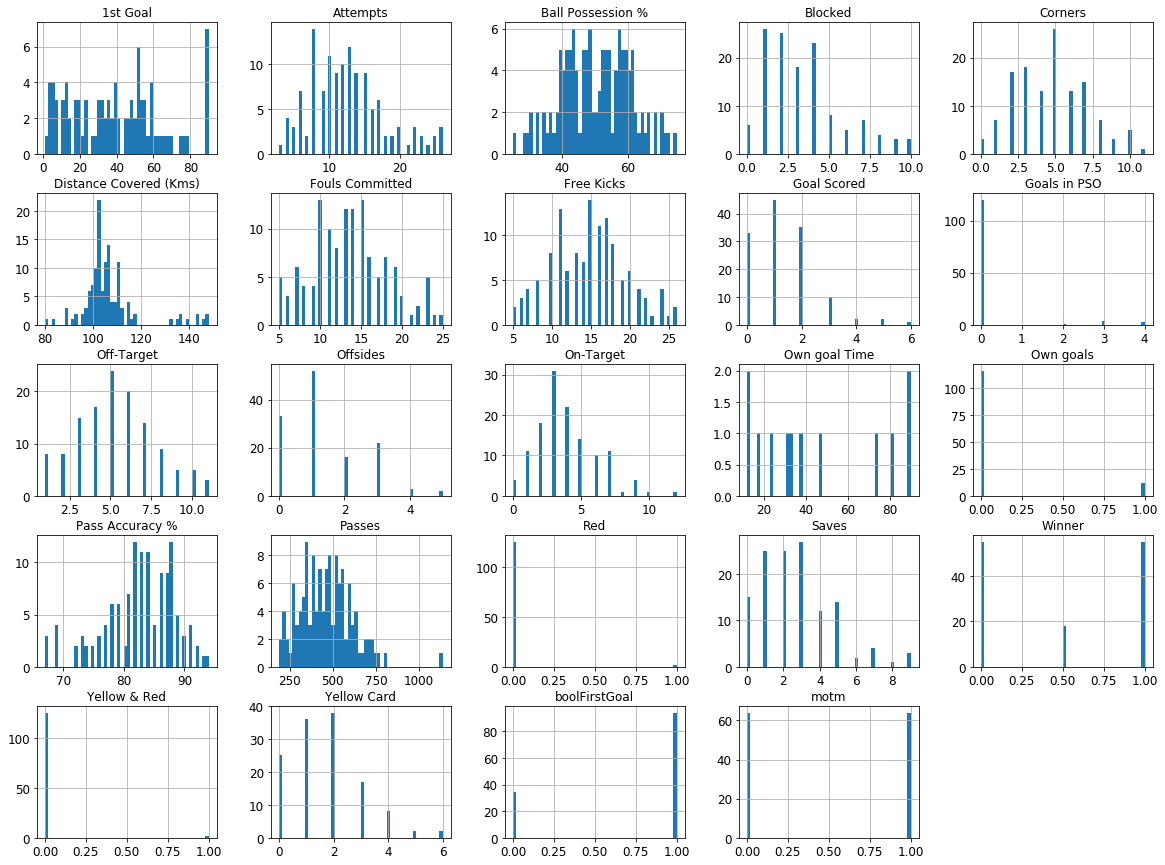

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))

plt.show()

Ovenfor kan vi se histogrammer for de forskjellige attributtene.

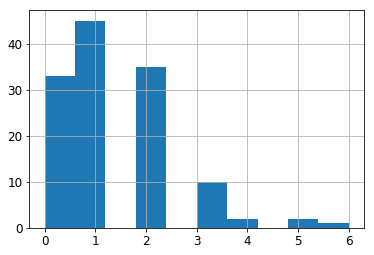

In [18]:
data["Goal Scored"].hist()

Her kan vi se at 0, 1 og 2 blir oftest representert i attributten Goal Scored

In [19]:
fs_copy = data.copy() #Kopi av datasettet

Nå skal vi se på korrelasjonen til de andre attrubuttene har til attributten motm(Man of the Match). Korrelasjonen sier oss hvordan de andre attributtene i raden samsvarer med om laget hadde motm. 

In [20]:
corr_matrix = fs_copy.corr()

In [21]:
corr_matrix["motm"].sort_values(ascending=False)

motm                      1.000000
Winner                    0.825895
boolFirstGoal             0.530662
Goal Scored               0.522193
On-Target                 0.291346
Attempts                  0.176425
Corners                   0.173148
Off-Target                0.152979
Free Kicks                0.119534
Ball Possession %         0.110393
Pass Accuracy %           0.109709
Passes                    0.101421
Goals in PSO              0.038873
Offsides                  0.026288
Distance Covered (Kms)    0.015353
1st Goal                  0.009802
Yellow & Red              0.000000
Blocked                  -0.019582
Saves                    -0.034443
Own goals                -0.107211
Red                      -0.125988
Fouls Committed          -0.129047
Yellow Card              -0.147934
Own goal Time            -0.186824
Name: motm, dtype: float64

Vi kan se ut i fra metoden corr_matrix hvilke av attributtene som har høy og lav korrelasjon til motm.
Winner som vi lagde har helt klart høyest korrelasjon til som har motm med 82,58%.
boolFirstGoal og Goal Scored ligger bak med rundt 50%. Ser vi derimot i andre enda av skalaen Own Goal Time, Yellow Card og Fouls Committed.
har negativ korrelasjon til motm. Dette tilsvarer at det er negativt for motm å ha høy verdi i disse. 

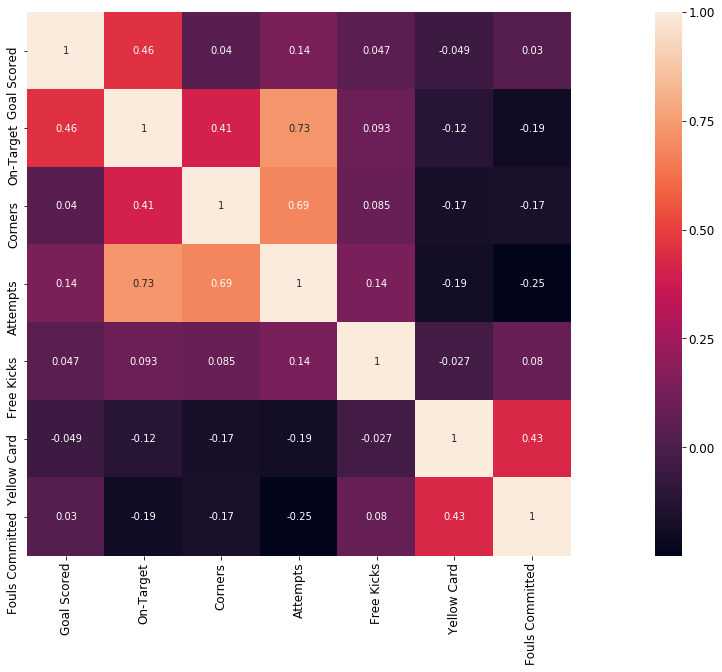

In [22]:
plt.figure(figsize=(30,10))
sns.heatmap(data[data_utdrag].corr(), square=True, annot=True,robust=True, yticklabels=1)

Ved hjelp av heatmap, ser vi de ulike korrelasjonene mellom de forskjellige attributtene. Blant annet har attempts og on-target naturlig nok høy korrelasjon. Vi bestemmer oss for å teste ut om vi kan skape nye attributter utifra de gitte attributtene. Vi tester å lage on-target-accuracy og set pieces. 

In [23]:
fs_copy["On-Target-Accuracy"] = fs_copy["On-Target"]/(fs_copy["On-Target"] + fs_copy["Off-Target"])

In [24]:
fs_copy["Set pieces"] = fs_copy["Corners"] + fs_copy["Free Kicks"] 

In [25]:
corr_matrix = fs_copy.corr()
corr_matrix["motm"].sort_values(ascending=False)

motm                      1.000000
Winner                    0.825895
boolFirstGoal             0.530662
Goal Scored               0.522193
On-Target                 0.291346
Set pieces                0.179617
Attempts                  0.176425
Corners                   0.173148
On-Target-Accuracy        0.160375
Off-Target                0.152979
Free Kicks                0.119534
Ball Possession %         0.110393
Pass Accuracy %           0.109709
Passes                    0.101421
Goals in PSO              0.038873
Offsides                  0.026288
Distance Covered (Kms)    0.015353
1st Goal                  0.009802
Yellow & Red              0.000000
Blocked                  -0.019582
Saves                    -0.034443
Own goals                -0.107211
Red                      -0.125988
Fouls Committed          -0.129047
Yellow Card              -0.147934
Own goal Time            -0.186824
Name: motm, dtype: float64

On-Target-Accuracy får en korrelasjon på 16 %, i mens Set pieces får 18%. 

# Prepare the data

Nå skal vi klargjøre dataen til modellene. Her skal vi velge hvilke attributter vi skal bruke i modellene våre og deler inn data-settet i test-sett og treningssett. Innledningsvis tar vi ut motm frå datasettet, slik at den ikke ødelegger for modellene. 

In [26]:
motm = fs_copy['motm']

I utgangspunktet dropper vi de attributtene som har korrelasjon rundt 0. Vi dropper også de hadde mange manglende verdier; siden et stort antall manglende data kan være vanskelig å fylle inn med meningsfull data. De attributtene som ikke har numeriske verdier(Date, round, team, opponent, PSO),
For eksempel ryker 1st Goal, når vi har laget boolFirstGoal. For å unngå multikorrelasjon(Veldig lik data i et datasett) dropper vi også "Yellow & Red", "Free Kicks" og "Corners".

In [27]:

fs_copy = fs_copy.drop(["Date", "Team", "Opponent", "Man of the Match", "Round", "PSO", "1st Goal", "Own goal Time", "Yellow & Red", "Blocked", "Distance Covered (Kms)", "Goals in PSO", "Offsides", "Free Kicks", "Own goals", 
                        "Fouls Committed", "motm", "On-Target-Accuracy", "Saves", "Corners", "Passes"], axis = 1)

In [28]:
fs_copy.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Pass Accuracy %,Yellow Card,Red,boolFirstGoal,Winner,Set pieces
0,5,40,13,7,3,78,0,0,1.0,1.0,17
1,0,60,6,0,3,86,0,0,0.0,0.0,27
2,0,43,8,3,3,78,2,0,0.0,0.0,7
3,1,57,14,4,6,86,0,0,1.0,1.0,18
4,0,64,13,3,6,86,1,0,0.0,0.0,19


Her splitter vi datasettet i to. Treningssettet har dei 85 første radene og testsettet har dei siste 42. Vi klargjør trenings- og test-settene til bruk i de ulike modellene ved å reshape de. Denne inndelingen gir oss alle gruppespillskampene i treningssettet, og sluttspillskampene i test-settet. 

In [29]:
y = motm.iloc[:85]
x = fs_copy.iloc[:85]

In [30]:
x.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Pass Accuracy %,Yellow Card,Red,boolFirstGoal,Winner,Set pieces
0,5,40,13,7,3,78,0,0,1.0,1.0,17
1,0,60,6,0,3,86,0,0,0.0,0.0,27
2,0,43,8,3,3,78,2,0,0.0,0.0,7
3,1,57,14,4,6,86,0,0,1.0,1.0,18
4,0,64,13,3,6,86,1,0,0.0,0.0,19


In [31]:
y.head()

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: motm, dtype: float64

Dei resterande entries blir lagt til i test-settet.

In [32]:
x_test = fs_copy.iloc[85:127] 
y_test = motm[85:127]

# Explore many different models and short-list the best ones

Her skal vi teste de ulike modellene, og se hvor godt de treffer på å forutse hvilket lag som fikk man of the match. 

Vi vil bruke 3 forskjellige modeller; Decision tree, random forest og XGBOOST. Vi vil velge hvilken vi vil justere basert på resultatet av cross-validation. Vi vil også se på confusion matrix når vi skal bedømme.

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [34]:
def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

## Decision Tree

Beslutningstre-modellen gir oss eit tre, der dei viktigaste attributtene/features kjem først. Desse attributtene blir satt til ulike parameter, og veien videre i treet blir bestemt deretter. Til slutt ender vi på en beslutning i ein av leafes; ja eller nei(1 og 0);

In [35]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [36]:
# Decision Tree
decision_tree = tree.DecisionTreeClassifier(random_state=21, max_depth= 3)
decision_tree = decision_tree.fit(x, y)

In [37]:
cv_scores = cross_val_score(decision_tree, x, y, cv=5 ,scoring="f1")
print(cv_scores)

[0.8        0.84210526 0.77777778 0.77777778 0.5       ]


In [38]:
cv_scores.mean()

0.7395321637426899

Cross-validation f1-score er 73.9 % ved bruk av beslutningstre-modellen med max depth på 3.

In [39]:
dc_pred = cross_val_predict(decision_tree, x, y, cv=5)

In [40]:
dc_confusion_matrix = confusion_matrix(y, dc_pred)

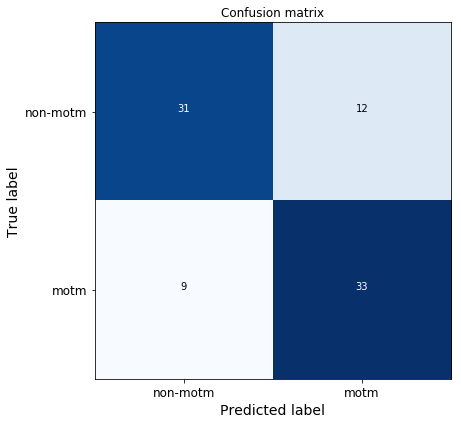

In [41]:
_ = plot_confusion_matrix(dc_confusion_matrix, classes=['non-motm', 'motm'])

## Random Forest

Random forest-modellen er en samling av mange små beslutnings-trær, og tar medianen når den tar den endelige beslutningen. Denne modellen hjelper på Decision-tree-modellens vane for å overfitte dataen. 

In [42]:
#Random forest
rf = RandomForestClassifier(random_state=21)
rf.fit(x, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

In [43]:
y_pred_forest = rf.predict(x)

Scoren på treningssett

In [44]:
rf.score(x, y)

0.9529411764705882

In [45]:
cv_scores1 = cross_val_score(rf, x, y, cv=5 ,scoring="f1")
print(cv_scores1)

[0.88888889 0.88888889 0.85714286 0.875      0.8       ]


In [46]:
cv_scores1.mean()

0.8619841269841271

86.2 % score på Cross-validation f1-score.

In [47]:
rf_pred = cross_val_predict(rf, x, y, cv=5)

In [48]:
rf_confusion_matrix = confusion_matrix(y, rf_pred)

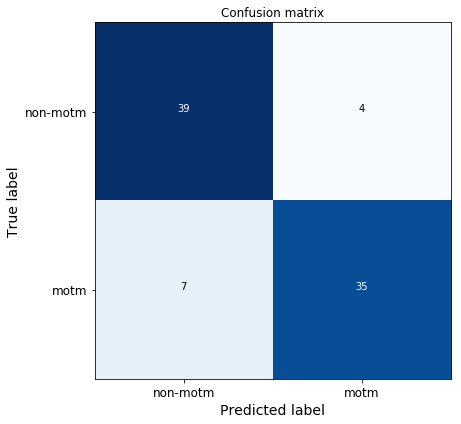

In [49]:
_ = plot_confusion_matrix(rf_confusion_matrix, classes=['non-motm', 'motm'])

## XGBoost

XGBoost-modellen er ein ensemble-modell, som bruker ulike svakere modeller og gjør de til strong learners ilag. Disse legges lag på lag. Den prøver å forbedre seg helt til et visst satt punkt.

In [50]:
import xgboost

In [51]:
from sklearn.model_selection import cross_val_score

In [52]:
xgb = xgboost.XGBClassifier(max_depth=3, n_estimators=20, learning_rate=0.05, random_state=21)

In [53]:
xgb.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [54]:
xgb.score(x,y)

0.8941176470588236

In [55]:
cv_scores3 = cross_val_score(xgb, x, y, cv=5 ,scoring="f1")
print(cv_scores3)

[0.84210526 0.88888889 0.94117647 0.75       0.8       ]


In [56]:
cv_scores3.mean()

0.8444341245270037

84.4 % cross-validation f1-score. 

In [57]:
xgb_pred = cross_val_predict(xgb, x, y, cv=5)

In [58]:
xgb_cm = confusion_matrix(y, xgb_pred)

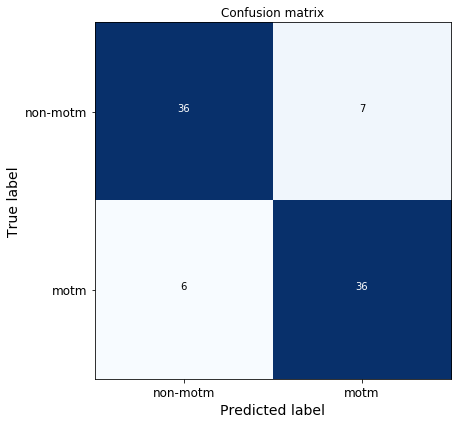

In [59]:
_ = plot_confusion_matrix(xgb_cm, classes=['non-motm', 'motm'])

# Fine-Tune Your Models and combine them into a great solution

Nå skal vi finjustere modellene. Vi baserer valget vårt på Cross-Valdidation-f1scoren og confusion matrix. Vi velger dermed Random Forest og XGBoost-modellene med videre for å justere. En måte er å justere hver enkelt hyperparameter manuelt. Vi skal derimot se på GridSearch når vi skal justere Random forest-modellen, som hjelper oss med å finne de beste innstillingene til hyperparametera. 

## Random Forest tuning

In [60]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True, False],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [ 4, 6, 8, 10],
    'n_estimators': [ 10, 15, 20, 50],
    'max_depth' : [2,3,4,5]
}

Etter prøving og feiling har vi funnet ut at disse 4 hyperparameterene har størst innvirkning på resultatet og velger dermed disse hyperparameterene for kryss-validering. 
På gridsearch-klassifiseringen har vi satt cv = 5 fold. Dette ga det beste resultatet.  

In [61]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='f1')

In [62]:
grid_search.fit(x, y)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:   31.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [4, 6, 8, 10], 'n_estimators': [10, 15, 20, 50], 'max_depth': [2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=2)

In [63]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 10}

In [64]:
rf2 = RandomForestClassifier(
    bootstrap = True,
     min_samples_leaf= 1,
 min_samples_split=5,
 n_estimators= 10,
    max_depth=5,
   random_state=21
) 


In [65]:
rf2.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=21, verbose=0, warm_start=False)

best_params gir oss våre forbedrede hyperparameter, som fører til en forbedring på ca 2 %.

In [66]:
cv_scores4 = cross_val_score(rf2, x, y, cv=5, scoring="f1")
print(cv_scores4)

[0.84210526 0.88888889 0.94117647 0.875      0.8       ]


In [67]:
cv_scores4.mean()

0.8694341245270036

86.9% cross val-f1-score. 0.7 % bedre enn før tuning.

In [68]:
rf2.score(x_test, y_test)

0.9285714285714286

Vi tester den ferdige Random Forest-modellen vår på testsettet. Dette gir en score på accuracy score på 92.85%. Denne vil vi sammenligne med XGBoost sin.

In [69]:
rf_pred3 = rf2.predict(x_test)

In [70]:
rf_confusion_matrix3 = confusion_matrix(y_test, rf_pred3)

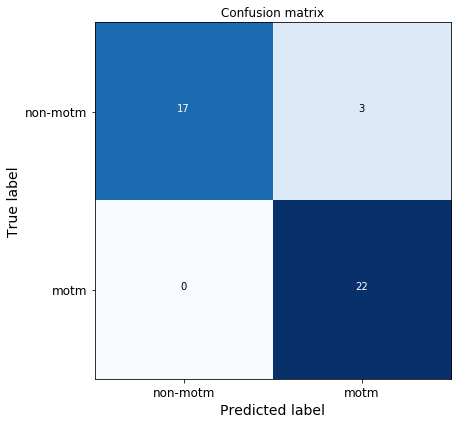

In [71]:
_ = plot_confusion_matrix(rf_confusion_matrix3, classes=['non-motm', 'motm'])

In [72]:
precision_score(y_test, rf_pred3)

0.88

In [73]:
recall_score(y_test, rf_pred3)

1.0

In [74]:
f1_score(y_test, rf_pred3)

0.9361702127659575

 ## XGBoost tuning

Vi velger å bruke randomized search cross-validation for å finne de beste parameterne til XGBoost-modellen.

In [75]:
from xgboost import plot_importance

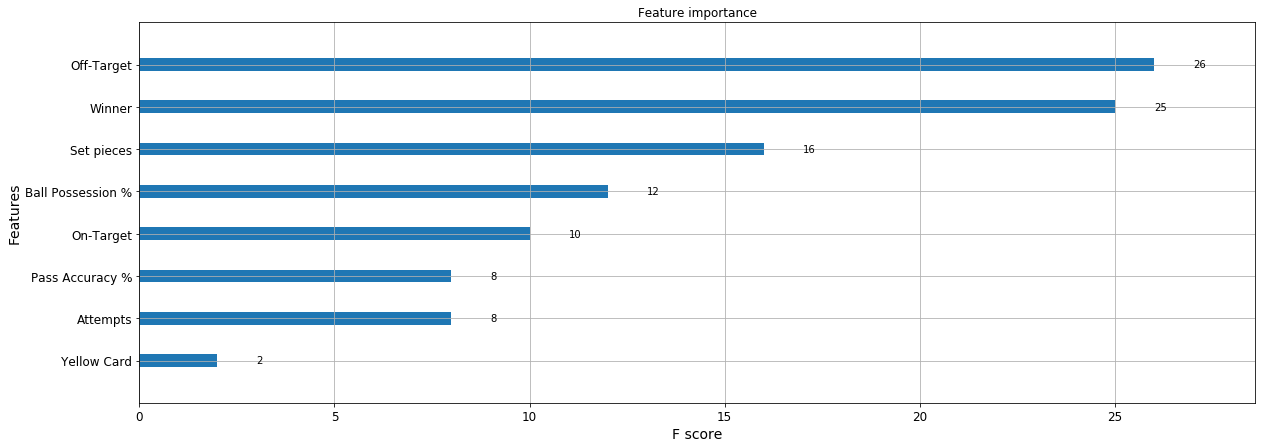

In [76]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_importance(xgb, ax=ax, height=0.3)

Feature importance forteller oss hvilke attributter som har hatt størst påvirkning på modellen. I vår modell topper Off-Target, Winner vår nye attributt Set pieces. 
Goal Scored, boolfirstgoal og red kommer ikke opp.  

In [77]:
fs_copy.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Pass Accuracy %,Yellow Card,Red,boolFirstGoal,Winner,Set pieces
0,5,40,13,7,3,78,0,0,1.0,1.0,17
1,0,60,6,0,3,86,0,0,0.0,0.0,27
2,0,43,8,3,3,78,2,0,0.0,0.0,7
3,1,57,14,4,6,86,0,0,1.0,1.0,18
4,0,64,13,3,6,86,1,0,0.0,0.0,19


In [78]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [79]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': [10, 20, 50, 100, 200, 500],
        'learning_rate': [0.05, 0.1, 0.15, 0.2]
        }

In [80]:
xgb3 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [81]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 21)

random_search = RandomizedSearchCV(xgb3, param_distributions=params, n_iter=param_comb, scoring='f1', n_jobs=4, cv=skf.split(x,y), verbose=3, random_state=1001 )

random_search.fit(x, y)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001A9268918B8>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=4,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5], 'n_estimators': [10, 20, 50, 100, 200, 500], 'learning_rate': [0.05, 0.1, 0.15, 0.2]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          return_train_score='warn', scoring='f1', verbose=3)

In [82]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.15,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [83]:
xgb_final = xgboost.XGBClassifier(max_depth=4, 
                             n_estimators=100, 
                             learning_rate=0.15, 
                             min_child_weight=5,
                             gamma=1.5,
                            max_delta_step = 0,
                            subsample = 1,
                            colsample_bytree =0.6,
                            alpha =0,
                            scale_pos_weight= 1,
                            objective= 'binary:logistic',
                            )

In [84]:
xgb_final.fit(x,y)

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=1.5, learning_rate=0.15,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [85]:
cv_scores6 = cross_val_score(xgb_final, x, y, cv=5, scoring="f1")
print(cv_scores6)

[0.88888889 0.88888889 0.94117647 0.875      0.71428571]


In [86]:
cv_scores6.mean()

0.8616479925303455

In [87]:
xgb_final.score(x_test, y_test)

0.9761904761904762

86.2 % cross-validation f1-score og 97.6 % accuracy score på test-settet.

In [88]:
test_predict = xgb_final.predict(x_test)

In [89]:
xgb_cm3 = confusion_matrix(y_test, test_predict)

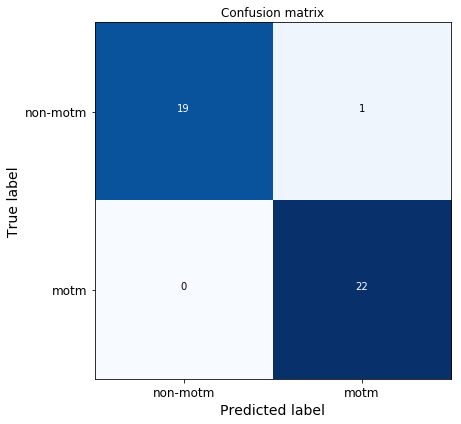

In [90]:
_ = plot_confusion_matrix(xgb_cm3, classes=['non-motm', 'motm'])

In [91]:
precision_score(y_test, test_predict)

0.9565217391304348

In [92]:
recall_score(y_test, test_predict)

1.0

In [93]:
f1_score(y_test, test_predict)

0.9777777777777777

# Present your solution

Etter å ha sett hvordan de to forskjellige modellene (random forest og xgboost) presterer både før og etter tuningen ender vi opp med å bruke xgboost-modellen. Cv-f1-scoren er tilnærma lik mellom Random Forest og XGBoost(0.6% favør Random Forest). XGBoost presterer derimot bedre på test-settet. 
Vi kan se ovenfor at xgboost har en 97.7% f1-score på test-settet. Random forest fikk vi 93.6% f1-score.


Målet vårt med dette prosjektet er å skape en god model som generaliserer godt utifra treningsdataen. Problemet med dette datasettet er at det er såpass lite at modellene ikke får nok trening. Testsett er også såpass lite(42 rader) at resultatet vårt kan være usikkert. Det kan gi lite meningsfulle estimat. Ideelt sett hadde vi hatt et større datasett.

Med et så lite datasett er det også stor mulighet for overfitting. 

Treningssettet vårt består bare i gruppespillskamper, dermed vil attributten 'Winner' sette uavgjort-kampene til 0.5. Dette kan medføre at denne attributten forstyrrer modellen når det kommer til testsettet og videre bruk av modellen. Vi burde kanskje brukt split-train-test metoden for å dele inn i trening- og testsett.

# Extra Material

## _!Viktig!_
For at denne neste datavisualiseringen skal vises må plotly være instalert ----> ($ pip install plotly) <----
(instalerses via pip)
i tillegg må ploty versionen være over: 1.9.4+ 
Test version med: 

import plotly

plotly.__ _version_ __

output: 'Din-versjon-her'

Oppdater plotly med:
_pip install plotly --upgrade_


In [94]:
# Navn på attributtene

labels=np.array(['Goal Scored', 'Attempts', 'Corners', 'Offsides', 'Free Kicks', 'Saves', 'Fouls Committed', 'Yellow Card'])

# Radar data for finalen, "France vs Croatia"
matchData1=data.loc[126,labels].values
matchData2=data.loc[127,labels].values

In [95]:
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

def radar_chart(matchData1,matchData2,name = "", name1 = ""):
    data = [go.Scatterpolar(r = matchData1,theta = labels,mode = 'lines',fill = 'toself',name = name),
        go.Scatterpolar(r = matchData2,theta = labels,mode = 'lines',fill = 'toself',name = name1)]
    layout = go.Layout(title ="Finale: " + name +" vs "+name1,polar = dict(radialaxis = dict(visible = True,range = [0, 20])),showlegend = True)
    fig = go.Figure(data=data, layout=layout)
    return plotly.offline.iplot(fig)

radar_chart(matchData1,matchData2,name="France", name1="Croatia")


In [96]:
motmFinal = xgb_final.predict(x_test)
motmFinal[41] #Croatia

1.0

Modellen vår anslår at Kroatia får Man of the Match i finalen. Dette er ikke så rart når en ser på radar_charten overfor. Dette er derimot en av feiltagelsene modellen vår gjør i test-settet.

## Kilder

Vi har brukt nettsiden der vi lastet ned datasettet, hvor vi har sett på andre sine notebooks. Både for inspirasjon og litt hjelp på veien(Kaggle.com). 

https://www.kaggle.com/ragnisah/eda-fifa2018-man-of-the-match-prediction6

https://www.kaggle.com/mathvv/seaborn-tutorial-and-fifa2018-mom-prediction

https://www.kaggle.com/ashishpatel26/plotly-graph-for-fifa-2018-man-of-the-match